# Example: Regression with `Adam`

In this notebook we demonstrate how to use the `Adam` optimizer to train an instance of the `QNNRegressor` to fit a logarithm.

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from squlearn import Executor
from squlearn.encoding_circuit import ChebyshevPQC
from squlearn.observables import SummedPaulis
from squlearn.qnn import QNNRegressor, SquaredLoss
from squlearn.qnn.util import get_variance_fac, ShotsFromRSTD
from squlearn.optimizers import Adam

We will use the Pennylane quantum framework for executing the circuits, we set the number of shots to consider a noisy simulator.

In [2]:
executor = Executor("pennylane", shots=5000)

## `QNNRegressor` Setup

We start by defining a parameterized quantum circuit (PQC)

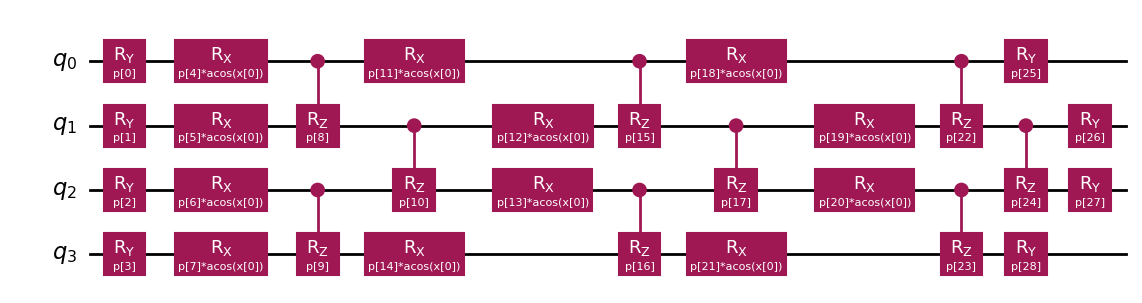

In [3]:
nqubits = 4
number_of_layers = 3

pqc = ChebyshevPQC(num_qubits=nqubits, num_layers=number_of_layers, closed=False)
pqc.draw("mpl", num_features=1)

We also need an observable

In [4]:
cost_op = SummedPaulis(nqubits)
print(cost_op)

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII'],
              coeffs=[ParameterExpression(1.0*p[0]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[2]), ParameterExpression(1.0*p[3]),
 ParameterExpression(1.0*p[4])])


Now we can create the `QNNRegressor` with the PQC and cost operator. We also specify `SquaredLoss` and `Adam` as the loss function and optimizer respectively. Finally we specify random initial parameters for both, the PQC and cost operator. For the `Adam` optimizer, we specify a maximum number of allowed iterations and a learning rate.

In [5]:
np.random.seed(13)
param_ini = np.array(
    [
        3.14604095,
        2.44401647,
        2.08568867,
        3.93000282,
        3.46433425,
        3.29501838,
        2.26917234,
        1.90319897,
        2.31709343,
        3.23543548,
        0.18238276,
        1.90898352,
        0.00505997,
        3.19126208,
        1.17116225,
        2.67742273,
        1.56371175,
        2.30711326,
        -1.38159894,
        2.24204365,
        4.51009492,
        1.12076568,
        1.05454309,
        4.0379626,
        2.35969077,
        0.1948755,
        1.00621795,
        2.22118908,
        -0.07067928,
    ]
)
param_op_ini = np.array([-0.62431099, 0.41142941, 0.01879568, 0.20331442, 0.393217])

ADAM = Adam({"maxiter": 10, "lr": 0.1})

reg = QNNRegressor(
    pqc,
    cost_op,
    executor,
    SquaredLoss(),
    ADAM,
    param_ini,
    param_op_ini,
    variance=get_variance_fac(0.005, 0.5, 5),
    shot_control=ShotsFromRSTD(0.1, 100, 5000),
)

## Training

Now we are ready to train the model to fit the logarithm funciton

In [6]:
X = np.arange(0.1, 0.9, 0.1).reshape(-1, 1)
y = np.log(X).ravel()

reg.fit(X, y)

fit: 100%|██████████| 10/10 [07:04<00:00, 42.42s/it]


## Evaluation

Let's check the trained parameters of the PQC and operator

In [7]:
print("Result PQC params:", reg.param)
print("Result operator params:", reg.param_op)

Result PQC params: [ 0.823351    2.1876066   1.54678356 -0.37110189 -0.60001478  1.4968881
  2.85399099  3.03347514  6.6147125  -0.62554018  4.37434105  0.54066507
  0.98194034  2.7260274   3.25105028 -6.08190745 -6.40637297  4.37037664
  0.64093026  1.63559851  2.7028605   3.26149152  0.16541527  4.22544475
 -3.90312843  1.48566994 -2.83077389  2.60889071 -0.30499027]
Result operator params: [-1.03284724 -0.26935283  0.19623405 -0.00242699 -0.06657044]


Also let's plot the predicted function vs. the actual logarithm function

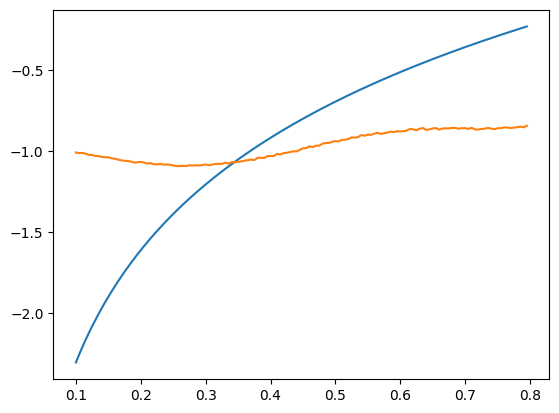

In [8]:
x = np.arange(np.min(X), np.max(X), 0.005).reshape(-1, 1)
y = reg.predict(x)
plt.plot(x, np.log(x))
plt.plot(x, y)